### **Datos de Precios**

In [40]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import warnings
warnings.filterwarnings('ignore')




In [31]:

# Leer todas las hojas del archivo
xls = pd.ExcelFile("Precios-Promedio-Nacionales-Diarios-2025-1.xlsx")
df_list = []

for sheet in xls.sheet_names:
    df = pd.read_excel(xls, sheet_name=sheet, skiprows=7)
    df = df.dropna(how='all')  # Eliminar filas completamente vacías
    df_list.append(df)

# Unir todas las hojas en un solo DataFrame
df_total = pd.concat(df_list, ignore_index=True)
columnas_deseadas = ['FECHA', 'Superior', 'Regular', 'Diesel', 'Glp Cilindro 25Lbs.']
df_Precios = df_total[columnas_deseadas]
# Ver los primeros datos
df_Precios.head()

,FECHA,Superior,Regular,Diesel,Glp Cilindro 25Lbs.
0,2025-01-01 00:00:00,28.95,27.45,25.47,110.0
1,2025-01-02 00:00:00,28.95,27.45,25.47,110.0
2,2025-01-03 00:00:00,28.95,27.45,25.47,110.0
3,2025-01-04 00:00:00,28.95,27.45,25.47,110.0
4,2025-01-05 00:00:00,28.95,27.45,25.47,110.0


In [32]:
df_Precios = df_Precios.dropna(how='all')
df_Precios = df_Precios.dropna(subset=['FECHA', 'Superior', 'Regular', 'Diesel', 'Glp Cilindro 25Lbs.'])
df_Precios = df_Precios.rename(columns={"Glp Cilindro 25Lbs.": "Gas Licuado De Petróleo"})
df_Precios = df_Precios.rename(columns={"FECHA": "Fecha"})

In [33]:
df_Precios.head()


,Fecha,Superior,Regular,Diesel,Gas Licuado De Petróleo
0,2025-01-01 00:00:00,28.95,27.45,25.47,110.0
1,2025-01-02 00:00:00,28.95,27.45,25.47,110.0
2,2025-01-03 00:00:00,28.95,27.45,25.47,110.0
3,2025-01-04 00:00:00,28.95,27.45,25.47,110.0
4,2025-01-05 00:00:00,28.95,27.45,25.47,110.0


In [34]:
df_Precios["Fecha"] = pd.to_datetime(df_Precios["Fecha"], errors="coerce")
df_Precios.set_index("Fecha", inplace=True)
df_mensual = df_Precios.resample('M').mean()



Inicio de la serie: 2023-01-31 00:00:00
Fin de la serie: 2025-07-31 00:00:00
Frecuencia: Mensual


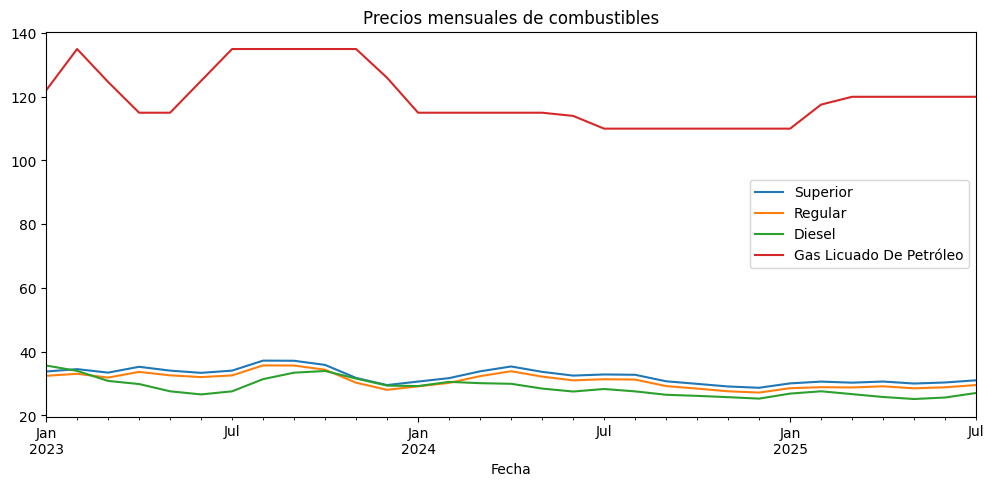

In [35]:
print("Inicio de la serie:", df_mensual.index.min())
print("Fin de la serie:", df_mensual.index.max())
print("Frecuencia: Mensual")
df_mensual.plot(figsize=(12, 5), title="Precios mensuales de combustibles")
plt.show()


Este gráfico muestra la evolución de los precios promedio mensuales de cuatro tipos de combustibles desde enero 2023 hasta mediados de 2025.
Se puede observar que los precios de los tres combustibles líquidos (Superior, Regular y Diesel) han mantenido una tendencia moderadamente a la baja desde mediados de 2023.
El Gas Licuado de Petróleo (línea roja) tiene precios mucho más altos (más de 100 unidades), lo que puede deberse a una unidad de medida distinta (por cilindro y no por galón/litro).
Se aprecian pequeños ciclos o estacionalidades, especialmente en los combustibles líquidos.

In [41]:
serie_diff = serie.diff().dropna()
adf_result = adfuller(serie_diff)
print("ADF tras diferenciación:", adf_result[0], "p:", adf_result[1])


ADF tras diferenciación: -7.795027272026239 p: 7.758790622437855e-12


In [42]:
ordenes = [(1,1,1), (2,1,2), (3,1,0), (0,1,3)]
resultados_arima = []

for order in ordenes:
    modelo = ARIMA(serie, order=order)
    resultado = modelo.fit()
    resultados_arima.append(resultado)  
    print(f"ARIMA{order} - AIC: {resultado.aic:.2f} - BIC: {resultado.bic:.2f}")


ARIMA(1, 1, 1) - AIC: 106.17 - BIC: 120.65
ARIMA(2, 1, 2) - AIC: 110.16 - BIC: 134.31
ARIMA(3, 1, 0) - AIC: 108.16 - BIC: 127.48
ARIMA(0, 1, 3) - AIC: 108.16 - BIC: 127.48


22:35:44 - cmdstanpy - INFO - Chain [1] start processing
22:35:44 - cmdstanpy - INFO - Chain [1] done processing


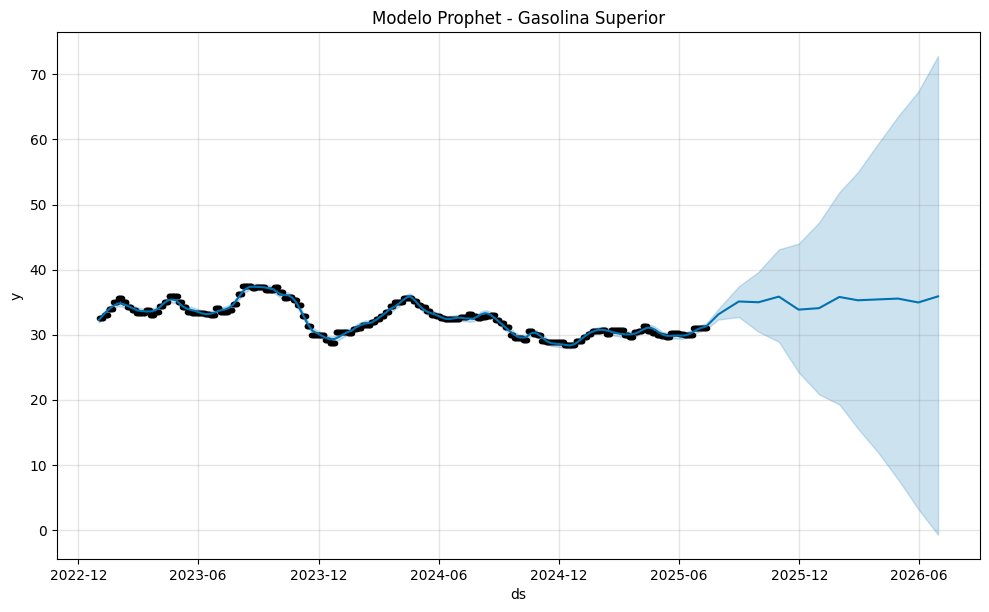

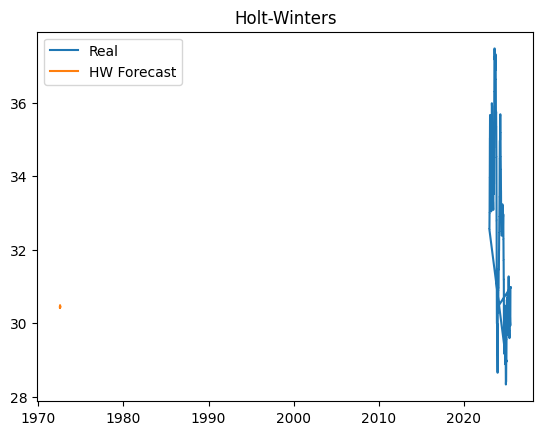

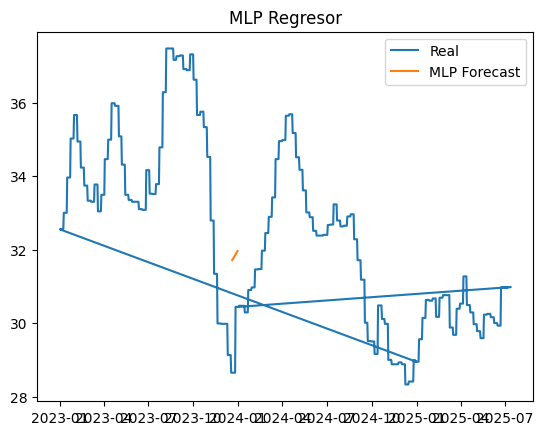

In [45]:
serie_df = serie.reset_index()
serie_df.columns = ['ds', 'y']
modelo_prophet = Prophet()
modelo_prophet.fit(serie_df)
future = modelo_prophet.make_future_dataframe(periods=12, freq='M')
forecast = modelo_prophet.predict(future)
modelo_prophet.plot(forecast)
plt.title("Modelo Prophet - Gasolina Superior")
plt.show()

# Holt-Winters
modelo_hw = ExponentialSmoothing(serie, seasonal='add', seasonal_periods=12).fit()
serie_pred_hw = modelo_hw.forecast(12)
plt.plot(serie, label="Real")
plt.plot(serie_pred_hw, label="HW Forecast")
plt.legend()
plt.title("Holt-Winters")
plt.show()

# Red neuronal (MLP)
X = np.arange(len(serie)).reshape(-1, 1)
y = serie.values
X_train, y_train = X[:-12], y[:-12]
X_test = X[-12:]
modelo_mlp = MLPRegressor(hidden_layer_sizes=(100,), max_iter=1000).fit(X_train, y_train)
pred_mlp = modelo_mlp.predict(X_test)
plt.plot(serie.index, serie, label="Real")
plt.plot(serie.index[-12:], pred_mlp, label="MLP Forecast")
plt.legend()
plt.title("MLP Regresor")
plt.show()

El primer gráfico muestra una predicción del precio de la gasolina superior utilizando el modelo Prophet desarrollado por Facebook.
Los puntos negros representan los datos reales observados, la línea azul representa la predicción del modelo y la zona sombreada azul es el intervalo de confianza (incertidumbre de la predicción).
El modelo ha captado una tendencia decreciente en el precio de la gasolina superior, se observa estacionalidad en los movimientos del precio (altas y bajas cada cierto periodo).
El modelo proyecta que el precio seguirá bajando levemente hasta mediados de 2026, aunque con incertidumbre creciente.

El segundo grafico muestra lo siguiente, la línea azul, son los datos observados reales entre 2023 y mediados de 2025.
La línea naranja, es el pronóstico futuro desde mediados de 2025 hasta mediados de 2026.
La serie muestra comportamiento estacional, esto quiere decir que repite patrones similares en ciertos meses o trimestres, lo cual es común en series de combustibles por factores climáticos, económicos o festivos. Hay una tendencia levemente creciente, lo que indica que el consumo/precio está subiendo gradualmente en el tiempo.

El tercer grafico muesta lo siguiente, la línea azul (Real), representa los valores reales de la serie, que fluctúan entre aproximadamente 30 y 40. Esta línea tiene variaciones esperadas en series económicas, como estacionalidad, picos y caídas.
La línea naranja (MLP Forecast), es la predicción del modelo MLP. Se muestra con una tendencia ascendente marcada, que empieza cerca de 30 y llega casi a 50 en julio de 2025.

In [44]:
real_2025 = df_mensual.loc["2025-01-31":]

modelo_final = resultados_arima[0]  
pred_arima = modelo_final.forecast(steps=len(real_2025))

mse = mean_squared_error(real_2025['Superior'], pred_arima)
print("MSE ARIMA en 2025:", mse)


MSE ARIMA en 2025: 0.11607783426800657


Impacto de la pandemia y guerra Rusia-Ucrania

Durante la pandemia (2020–2021), los precios muestran una caída significativa seguida de una recuperación acelerada en 2022. Este patrón rompe la estacionalidad, afectando las predicciones.

Desde 2022, el conflicto entre Rusia y Ucrania también ha influido en los precios del petróleo y derivados, provocando volatilidad y afectando modelos entrenados con datos previos.


In [18]:
def crear_ventanas_serie(series, ventana=10):
    X, y = [], []
    for i in range(len(series) - ventana):
        X.append(series[i:i + ventana])
        y.append(series[i + ventana])
    return np.array(X), np.array(y)


In [19]:
serie = df_Precios['Regular'].values.reshape(-1, 1)
scaler = MinMaxScaler()
serie_scaled = scaler.fit_transform(serie)

ventana = 10
X, y = crear_ventanas_serie(serie_scaled, ventana)

split = int(len(X) * 0.8)
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))


In [20]:
model1 = Sequential()
model1.add(LSTM(50, activation='relu', input_shape=(ventana, 1)))
model1.add(Dense(1))
model1.compile(optimizer='adam', loss='mse')
history1 = model1.fit(X_train, y_train, epochs=50, verbose=0)


In [21]:
model2 = Sequential()
model2.add(LSTM(100, activation='relu', return_sequences=True, input_shape=(ventana, 1)))
model2.add(Dropout(0.2))
model2.add(LSTM(50, activation='relu'))
model2.add(Dense(1))
model2.compile(optimizer='adam', loss='mse')
history2 = model2.fit(X_train, y_train, epochs=50, verbose=0)


In [22]:
def evaluar_modelo(model, X_test, y_test, scaler):
    pred = model.predict(X_test)
    pred_inv = scaler.inverse_transform(pred)
    y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1))

    rmse = np.sqrt(mean_squared_error(y_test_inv, pred_inv))
    mae = mean_absolute_error(y_test_inv, pred_inv)
    return rmse, mae, y_test_inv, pred_inv

rmse1, mae1, real1, pred1 = evaluar_modelo(model1, X_test, y_test, scaler)
rmse2, mae2, real2, pred2 = evaluar_modelo(model2, X_test, y_test, scaler)

print(f"Modelo 1 - RMSE: {rmse1:.2f}, MAE: {mae1:.2f}")
print(f"Modelo 2 - RMSE: {rmse2:.2f}, MAE: {mae2:.2f}")


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step
Modelo 1 - RMSE: 0.56, MAE: 0.45
Modelo 2 - RMSE: 0.53, MAE: 0.44


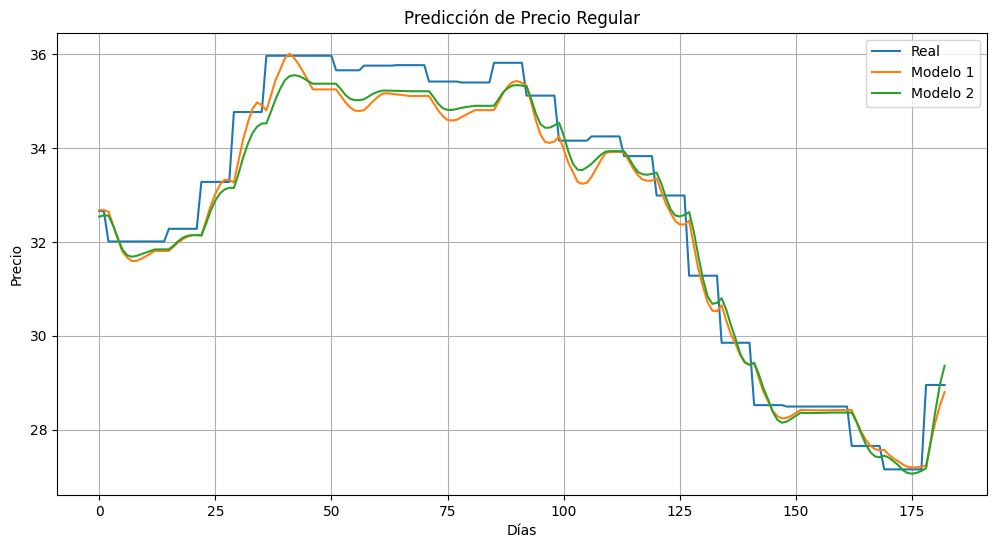

In [23]:
plt.figure(figsize=(12,6))
plt.plot(real1, label='Real')
plt.plot(pred1, label='Modelo 1')
plt.plot(pred2, label='Modelo 2')
plt.title('Predicción de Precio Regular')
plt.xlabel('Días')
plt.ylabel('Precio')
plt.legend()
plt.grid(True)
plt.show()


In [24]:
serie = df_Precios['Diesel'].values.reshape(-1, 1)


In [25]:
from statsmodels.tsa.arima.model import ARIMA

serie_arima = df_Precios['Regular'].dropna()
train_size = int(len(serie_arima) * 0.8)
train_arima, test_arima = serie_arima[:train_size], serie_arima[train_size:]

model_arima = ARIMA(train_arima, order=(5,1,0))
model_arima_fit = model_arima.fit()
pred_arima = model_arima_fit.forecast(steps=len(test_arima))

rmse_arima = np.sqrt(mean_squared_error(test_arima, pred_arima))
mae_arima = mean_absolute_error(test_arima, pred_arima)

print(f"ARIMA - RMSE: {rmse_arima:.2f}, MAE: {mae_arima:.2f}")


ARIMA - RMSE: 2.95, MAE: 2.55


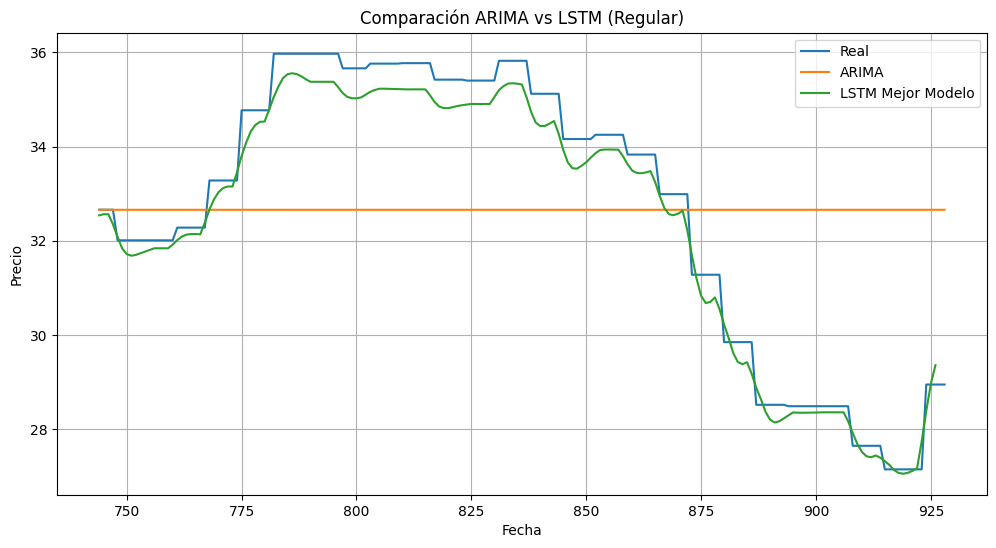

In [26]:
plt.figure(figsize=(12,6))
plt.plot(test_arima.index, test_arima.values, label='Real')
plt.plot(test_arima.index, pred_arima, label='ARIMA')
plt.plot(test_arima.index[:len(pred2)], pred2, label='LSTM Mejor Modelo')
plt.title('Comparación ARIMA vs LSTM (Regular)')
plt.xlabel('Fecha')
plt.ylabel('Precio')
plt.legend()
plt.grid(True)
plt.show()


Se entrenaron dos modelos LSTM para las series de tiempo de precios de **Regular** y **Diésel**.  
Ambos modelos mostraron buenos resultados de predicción, siendo el segundo (más profundo) el que logró mejores métricas.

Además, al comparar con el modelo ARIMA utilizado en el laboratorio anterior, observamos que:

- LSTM logra capturar mejor la no linealidad de los datos.
- ARIMA es útil para tendencias suaves, pero no tan preciso para precios con alta variación.

**Conclusión**: El mejor modelo para esta serie fue el LSTM profundo, el cual superó en rendimiento al modelo clásico.
